In [59]:
import os
import sys
import os
from typing import Tuple

sys.path.append("../")
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from experiments.experiments_utils import (
    load_json,
    load_model,
    deactivate_dropout_layers,
    load_raw_images,
    load_object,
)
from experiments.models.vit import PatchDecoder

# Is ViT trained enough for our purpose?

Here are the decoded ViT embeddings for MNIST and CIFAR10:

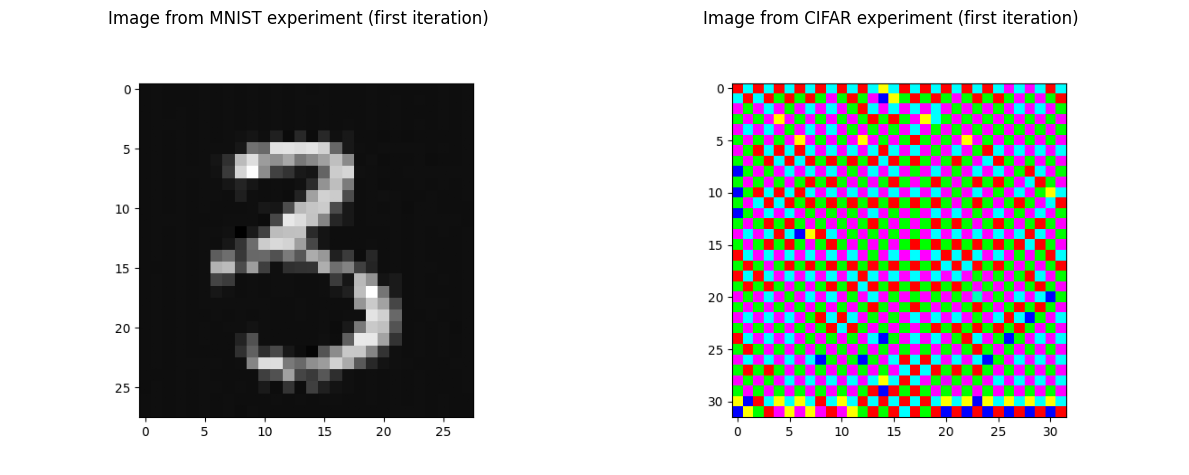

In [31]:
# Paths to the images
image_path1 = "/Users/lizzy/research/input-space-inspection/res/mnist-1-2-all-20241121-143522/simec-img_5000-1/interpretation/patches-0-2-exploration-capping-7.png"
image_path2 = "/Users/lizzy/research/input-space-inspection/res/cifar-1-2-all-20241121-083609/simec-img_1978-1/interpretation/patches-0-8-exploration-capping-2.png"

# Load images
image1 = mpimg.imread(image_path1)
image2 = mpimg.imread(image_path2)

# Display images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axes[0].imshow(image1)
axes[0].axis("off")  # Hide axes
axes[0].set_title("Image from MNIST experiment (first iteration)")

axes[1].imshow(image2)
axes[1].axis("off")  # Hide axes
axes[1].set_title("Image from CIFAR experiment (first iteration)")

plt.tight_layout()
plt.show()

Things to check:

- Is the decoder working properly for the two models? -> Try encoding and decoding an image with no modification to the input embedding. I expect a similar result as above.
- Why is this message appearing when interpreting CIFAR experiments: *Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1087.4214..1036.6598].* -> Inspect the decoded embedding values (min e max) for the two experiments

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MNIST Input Image size: torch.Size([1, 28, 28])
MNIST Input Image min value: 0.0
MNIST Input Image max value: 254.0
Original Image Distribution Quantiles:
  0th quantile: 0.000000	  25th quantile: 0.000000	  50th quantile: 0.000000	  75th quantile: 0.000000	  100th quantile: 254.000000	

Input Embedding Distribution Quantiles:
  0th quantile: -611.158875	  25th quantile: -0.501806	  50th quantile: 0.072847	  75th quantile: 0.707614	  100th quantile: 729.390137	

MNIST Decoded Image size: torch.Size([1, 28, 28])
MNIST Decoded Image min value: -4.1708281059982255e-05
MNIST Decoded Image max value: 254.00010681152344


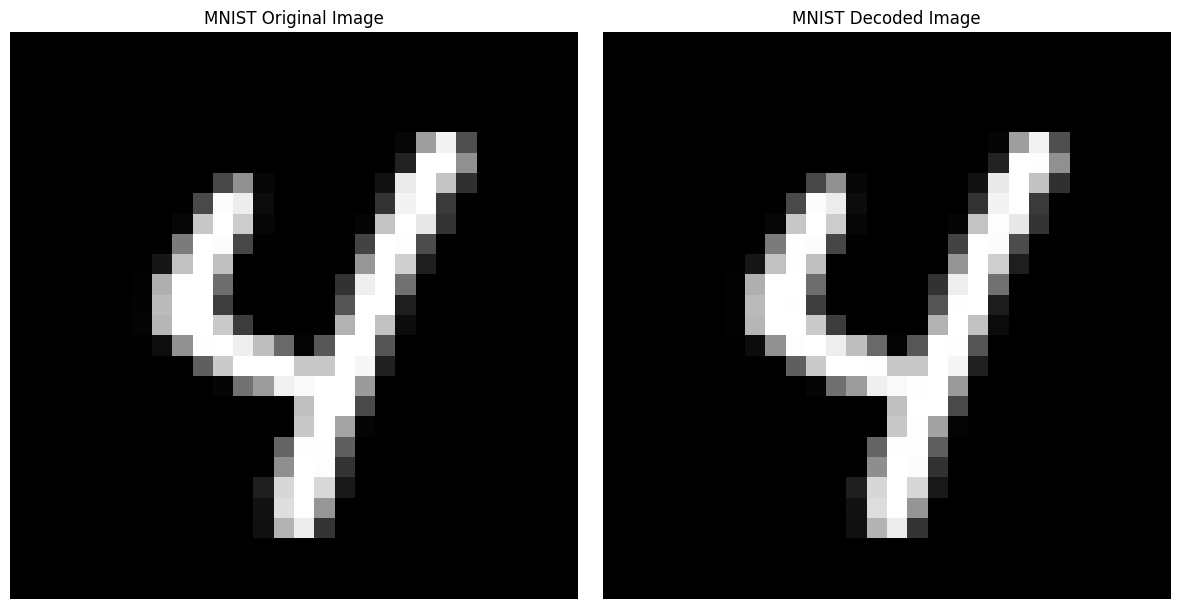

CIFAR Input Image size: torch.Size([3, 32, 32])
CIFAR Input Image min value: 9.0
CIFAR Input Image max value: 240.0
Original Image Distribution Quantiles:
  0th quantile: 9.000000	  25th quantile: 98.000000	  50th quantile: 132.000000	  75th quantile: 163.000000	  100th quantile: 240.000000	

Input Embedding Distribution Quantiles:
  0th quantile: -992.281982	  25th quantile: -113.682144	  50th quantile: -11.451717	  75th quantile: 73.378387	  100th quantile: 1094.734009	

CIFAR Decoded Image size: torch.Size([3, 32, 32])
CIFAR Decoded Image min value: 9.000005722045898
CIFAR Decoded Image max value: 240.00025939941406


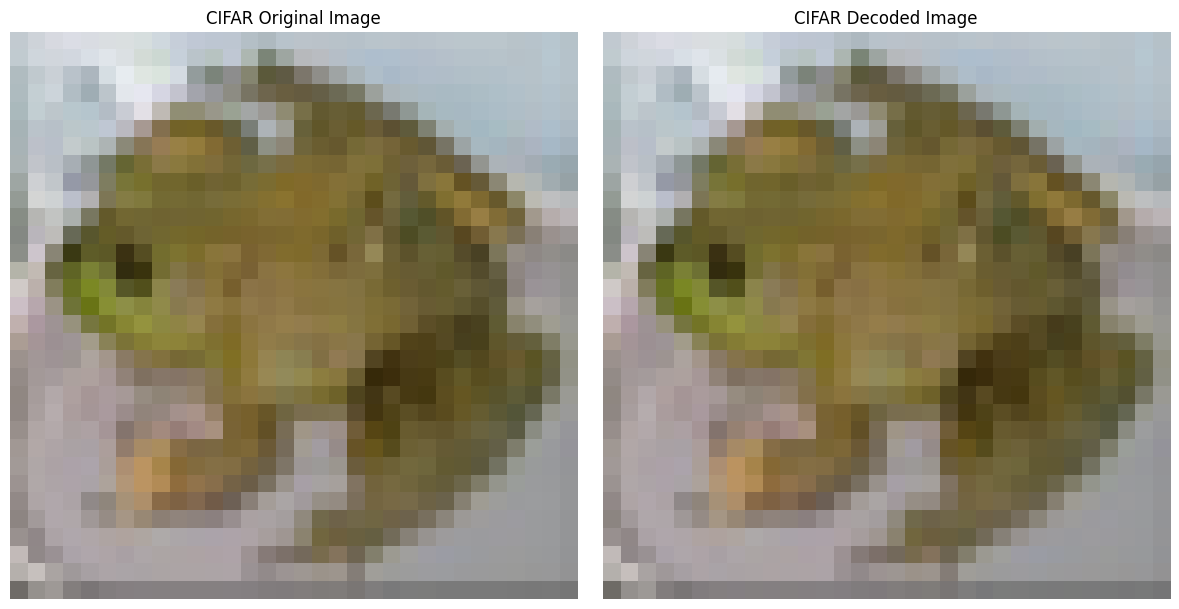

In [100]:
def print_quantiles(distribution, name, quantiles, device):
    """
    Calculate and print the quantiles for a given distribution.

    Args:
        distribution (torch.Tensor): The tensor containing the distribution values.
        name (str): The name of the distribution (e.g., "CIFAR Min").
        quantiles (list): List of quantile values to compute (e.g., [0, 0.25, 0.5, 0.75, 1]).
        device (torch.device): The device to move the tensor to.
    """
    distribution = distribution.detach().to(device)
    quantile_values = torch.quantile(
        distribution, torch.tensor(quantiles, device=device)
    )

    print(f"{name} Distribution Quantiles:")
    for q, val in zip(quantiles, quantile_values):
        print(f"  {int(q * 100)}th quantile: {val.item():.6f}", end="\t")
    print("\n")  # Add a newline for better formatting


def log_image_info(image: torch.Tensor, name: str = "Image") -> None:
    """Log basic info about an image tensor."""
    print(f"{name} size: {image.size()}")
    print(f"{name} min value: {torch.min(image).item()}")
    print(f"{name} max value: {torch.max(image).item()}")


def load_model_and_decoder(
    parameters: dict, device: torch.device
) -> Tuple[torch.nn.Module, torch.nn.Module]:
    """Load a model and its corresponding decoder."""
    model_path = os.path.join("../", parameters["model_path"])
    model_filename = [f for f in os.listdir(model_path) if f.endswith(".pt")]
    if not model_filename:
        raise FileNotFoundError(f"No model file found in {model_path}")

    model, _ = load_model(
        model_path=os.path.join(model_path, model_filename[0]),
        config_path=os.path.join(model_path, "config.json"),
        device=device,
    )
    deactivate_dropout_layers(model)
    model = model.to(device)

    decoder = PatchDecoder(
        image_size=model.image_size,
        patch_size=model.embedding.patch_size,
        model_embedding_layer=model.embedding,
    ).to(device)
    return model, decoder


def visualize_images(
    original: torch.Tensor, decoded: torch.Tensor, dataset: str
) -> None:
    """Display original and decoded images side by side."""
    # Check if the image is grayscale or RGB
    is_grayscale = original.size(0) == 1

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Original image
    axes[0].imshow(
        original.to(torch.int).permute(1, 2, 0), cmap="gray" if is_grayscale else None
    )
    axes[0].axis("off")
    axes[0].set_title(f"{dataset} Original Image")

    # Decoded image
    axes[1].imshow(
        decoded.to(torch.int).permute(1, 2, 0).detach().cpu().numpy(),
        cmap="gray" if is_grayscale else None,
    )
    axes[1].axis("off")
    axes[1].set_title(f"{dataset} Decoded Image")

    plt.tight_layout()
    plt.show()


def encode_decode(
    decoder: torch.nn.Module,
    model: torch.nn.Module,
    image: torch.Tensor,
    dataset: str,
    quantiles: list = [0, 0.25, 0.5, 0.75, 1],
    q_only: bool = False,
) -> None:
    """Encode and decode an image using the model and decoder."""
    log_image_info(image, f"{dataset} Input Image")

    print_quantiles(image, "Original Image", quantiles, device)

    # Encode original images
    input_patches = model.patcher(image.unsqueeze(0))
    input_embedding = model.embedding(input_patches)

    print_quantiles(input_embedding, "Input Embedding", quantiles, device)

    # Decode embeddings
    decoded_image = decoder(input_embedding.to(device))[0]
    log_image_info(decoded_image, f"{dataset} Decoded Image")

    if not q_only:
        # Visualize the results
        visualize_images(image, decoded_image, dataset)


# Constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cifar_experiment_path = "/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/cifar-1-2-all"
mnist_experiment_path = "/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/mnist-1-2-all"

# Load parameters
cifar_parameters = load_json(os.path.join(cifar_experiment_path, "parameters.json"))
mnist_parameters = load_json(os.path.join(mnist_experiment_path, "parameters.json"))

# Load models and decoders
cifar_model, cifar_decoder = load_model_and_decoder(cifar_parameters, device)
mnist_model, mnist_decoder = load_model_and_decoder(mnist_parameters, device)

# Load and process images
mnist_image = load_raw_images(mnist_experiment_path)[0][0].to(device)
cifar_image = load_raw_images(cifar_experiment_path)[0][0].to(device)

# Encode and decode images
encode_decode(mnist_decoder, mnist_model, mnist_image, "MNIST")
encode_decode(cifar_decoder, cifar_model, cifar_image, "CIFAR")

We can exclude that the decoder is the problem: it can decode images without changes.

- Is the decoder working properly for the two models? -> Yes
- Why is this message appearing when interpreting CIFAR experiments: *Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1087.4214..1036.6598].* -> Because it wants either floats from 0 to 1 or integers from 0 to 255. However, why are the values so far away from the admissible ones?

Next: evaluate the min and max values distributions for MNIST and CIFAR.

In [96]:
# Paths
cifar_results_path = (
    "/Users/lizzy/research/input-space-inspection/res/cifar-1-2-all-20241121-083609"
)
mnist_results_path = (
    "/Users/lizzy/research/input-space-inspection/res/mnist-1-2-all-20241121-143522"
)

# Quantiles to calculate
quantiles = [0, 0.25, 0.5, 0.75, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR distributions
cifar_min_distribution = load_object(
    os.path.join(cifar_results_path, "min_distribution.pkl")
)
cifar_max_distribution = load_object(
    os.path.join(cifar_results_path, "max_distribution.pkl")
)
print_quantiles(cifar_min_distribution, "CIFAR Min", quantiles, device)
print_quantiles(cifar_max_distribution, "CIFAR Max", quantiles, device)

# MNIST distributions
mnist_min_distribution = load_object(
    os.path.join(mnist_results_path, "min_distribution.pkl")
)
mnist_max_distribution = load_object(
    os.path.join(mnist_results_path, "max_distribution.pkl")
)
print_quantiles(mnist_min_distribution, "MNIST Min", quantiles, device)
print_quantiles(mnist_max_distribution, "MNIST Max", quantiles, device)

CIFAR Min Distribution Quantiles:
  0th quantile: 0.003884	  25th quantile: 24.393753	  50th quantile: 62.212154	  75th quantile: 155.602234	  100th quantile: 1039.821655	

CIFAR Max Distribution Quantiles:
  0th quantile: 0.003884	  25th quantile: 81.830132	  50th quantile: 156.133499	  75th quantile: 337.285095	  100th quantile: 1612.145020	

MNIST Min Distribution Quantiles:
  0th quantile: 0.000108	  25th quantile: 0.225982	  50th quantile: 0.504621	  75th quantile: 0.966200	  100th quantile: 676.687439	

MNIST Max Distribution Quantiles:
  0th quantile: 0.000226	  25th quantile: 0.340459	  50th quantile: 0.861707	  75th quantile: 53.723091	  100th quantile: 729.390137	



Both MNIST and CIFAR images are mapped to embeddings having values greater than 255, with the CIFAR values being much higher. Let's see which is the range of the two images that we have seen before.

In [98]:
encode_decode(mnist_decoder, mnist_model, mnist_image, "MNIST", q_only=True)
print("__________________________________________________")
encode_decode(cifar_decoder, cifar_model, cifar_image, "CIFAR", q_only=True)

MNIST Input Image size: torch.Size([1, 28, 28])
MNIST Input Image min value: 0.0
MNIST Input Image max value: 254.0
Original Image Distribution Quantiles:
  0th quantile: 0.000000	  25th quantile: 0.000000	  50th quantile: 0.000000	  75th quantile: 0.000000	  100th quantile: 254.000000	

Input Embedding Distribution Quantiles:
  0th quantile: -611.158875	  25th quantile: -0.501806	  50th quantile: 0.072847	  75th quantile: 0.707614	  100th quantile: 729.390137	

MNIST Decoded Image size: torch.Size([1, 28, 28])
MNIST Decoded Image min value: -4.1708281059982255e-05
MNIST Decoded Image max value: 254.00010681152344
__________________________________________________
CIFAR Input Image size: torch.Size([3, 32, 32])
CIFAR Input Image min value: 9.0
CIFAR Input Image max value: 240.0
Original Image Distribution Quantiles:
  0th quantile: 9.000000	  25th quantile: 98.000000	  50th quantile: 132.000000	  75th quantile: 163.000000	  100th quantile: 240.000000	

Input Embedding Distribution Quan

Why does the min distribution quantile have such a high min value? Here we see that the example images can have min values below 0.

There was a torch.abs() in the computation of minimum and maximum embeddings. However, why are the values going so far away from the admissible ones? *Got range [-1087.4214..1036.6598]*

Let's try with computing min and max distribution embeddings from all input instances in the dataset. Here I analyse these new distributions.

In [109]:
quantiles = [0, 0.25, 0.5, 0.75, 1]
for dataset_name in ["cifar", "mnist", "hatespeech", "winobias"]:
    patch = "all"
    if dataset_name == "winobias":
        patch = "target-word"
    new_max_distribution = load_object(
        f"/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/{dataset_name}-1-2-{patch}/max_distribution.pkl"
    )
    new_min_distribution = load_object(
        f"/Users/lizzy/research/input-space-inspection/transformers_equivalence_classes/experiments_data/test/{dataset_name}-1-2-{patch}/min_distribution.pkl"
    )
    print("Min distribution embeddings size: ", new_max_distribution.size())
    print("Max distribution embeddings size: ", new_max_distribution.size())
    print_quantiles(new_max_distribution, f"New {dataset_name} MAX", quantiles, device)
    print_quantiles(new_min_distribution, f"New {dataset_name} MIN", quantiles, device)

Min distribution embeddings size:  torch.Size([1, 257, 48])
Max distribution embeddings size:  torch.Size([1, 257, 48])
New cifar MAX Distribution Quantiles:
  0th quantile: -53.413635	  25th quantile: 215.163101	  50th quantile: 361.307678	  75th quantile: 557.798828	  100th quantile: 1502.773071	

New cifar MIN Distribution Quantiles:
  0th quantile: -1718.163452	  25th quantile: -578.236328	  50th quantile: -372.172394	  75th quantile: -222.776047	  100th quantile: 93.744537	

Min distribution embeddings size:  torch.Size([1, 197, 48])
Max distribution embeddings size:  torch.Size([1, 197, 48])
New mnist MAX Distribution Quantiles:
  0th quantile: -4.449617	  25th quantile: 0.467039	  50th quantile: 65.890991	  75th quantile: 192.233337	  100th quantile: 757.226501	

New mnist MIN Distribution Quantiles:
  0th quantile: -615.348694	  25th quantile: -137.228851	  50th quantile: -24.023994	  75th quantile: -0.187197	  100th quantile: 3.065415	

Min distribution embeddings size:  torch

These quantiles seem more reasonable with our embeddings.

Let's try running new experiments with these.

Using the maximum padding slows the experiment by a lot, but it is the most accurate way of capping embeddings.